In [84]:
from analyzer import PITCHfx, GameLogs, PlayerMap, EventInfo, Parks
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
h2o.init(min_mem_size='4G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_171"; Java(TM) SE Runtime Environment (build 1.8.0_171-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp74LnM0
  JVM stdout: /tmp/tmp74LnM0/h2o_ww_started_from_python.out
  JVM stderr: /tmp/tmp74LnM0/h2o_ww_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.5
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_ww_tc63zl
H2O cluster total nodes:,1
H2O cluster free memory:,3.833 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [4]:
def get_season(year, pitcher):
    ## combine PITCHfx and GameLogs for ease of analysis
    pfx = PITCHfx(year)+GameLogs(year)+EventInfo(year)+Parks()

    ## get name maps and merge with dataframe
    PM = PlayerMap()
    pfx.df['mlb_id'] = pfx.df['pitcher']
    PM.slim_frame(['mlb_id','retro_id','retro_name'])
    pfx = pfx+PM

    ## filter on pitcher retro id
    pfx.filter_by_pitchers(pitcher)
    return pfx

In [5]:
year=2017
pitchers=['lestj001','quinj001','montm002']
#pfx = sum([get_season(year, pitcher) for pitcher in pitchers])
pfx = get_season(year, pitchers)

In [6]:
pfx.df = pfx.df[(pfx.df.pitch_type!='UN') & (pfx.df.pitch_type.notna())]
hdf = h2o.H2OFrame(pfx.df)

/usr/local/lib/python2.7/dist-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
features = ['start_speed','spin_rate','spin_dir','pfx_z','break_angle','break_length','pitch_type','retro_id']
train, valid, test = hdf.split_frame([0.7,0.2])

In [8]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
## hidden layers: 128x128 ; Rectifier activation
Net_1 = H2ODeepLearningEstimator(epochs=100, hidden=[128,128], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=0.25, score_each_iteration=True, score_validation_sampling='Uniform')
## hidden layers: 512x512 ; Rectifier activation
Net_2 = H2ODeepLearningEstimator(epochs=100, hidden=[512,512], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=5, score_each_iteration=True, score_validation_sampling='Uniform')                                 
## hidden layers: 32x128x32 ; Rectifier activation
Net_3 = H2ODeepLearningEstimator(epochs=100, hidden=[64, 128, 64], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=0.25, score_each_iteration=True, score_validation_sampling='Uniform') 

## hidden layers: 512x512x10 ; Rectifier activation
Net_4 = H2ODeepLearningEstimator(epochs=100, hidden=[512,512,10], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=10, score_each_iteration=True, score_validation_sampling='Uniform') 

## hidden layers: 10x512x512x5; Rectifier activation
Net_5 = H2ODeepLearningEstimator(epochs=100, hidden=[10,512,512,5], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=20, score_each_iteration=True, score_validation_sampling='Uniform') 



In [27]:

## hidden layers: 512x512x32x8; Rectifier activation
Net_6 = H2ODeepLearningEstimator(epochs=100, hidden=[512,512,64,16], activation='RectifierWithDropout',
                                 classification_stop=-1, stopping_rounds=0,
                                 score_interval=20, score_each_iteration=True, score_validation_sampling='Uniform') 



In [10]:
Net_1.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)
Net_2.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)
Net_3.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)
Net_4.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)
Net_5.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [28]:
Net_6.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [11]:
print(Net_1.confusion_matrix(test))
print(Net_2.confusion_matrix(test))
print(Net_3.confusion_matrix(test))
print(Net_4.confusion_matrix(test))
print(Net_5.confusion_matrix(test))


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
81.0,0.0,1.0,1.0,0.0,0.0240964,2 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,109.0,10.0,0.0,0.0840336,10 / 119
0.0,0.0,2.0,354.0,1.0,0.0084034,3 / 357
0.0,0.0,0.0,1.0,112.0,0.0088496,1 / 113
81.0,173.0,112.0,366.0,113.0,0.0189349,16 / 845



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
82.0,0.0,1.0,0.0,0.0,0.0120482,1 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,112.0,7.0,0.0,0.0588235,7 / 119
0.0,0.0,5.0,351.0,1.0,0.0168067,6 / 357
0.0,0.0,0.0,3.0,110.0,0.0265487,3 / 113
82.0,173.0,118.0,361.0,111.0,0.0201183,17 / 845



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
81.0,0.0,2.0,0.0,0.0,0.0240964,2 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,110.0,9.0,0.0,0.0756303,9 / 119
0.0,0.0,4.0,352.0,1.0,0.0140056,5 / 357
0.0,0.0,0.0,6.0,107.0,0.0530973,6 / 113
81.0,173.0,116.0,367.0,108.0,0.0260355,22 / 845



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
83.0,0.0,0.0,0.0,0.0,0.0,0 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,113.0,6.0,0.0,0.0504202,6 / 119
0.0,0.0,6.0,350.0,1.0,0.0196078,7 / 357
0.0,0.0,0.0,3.0,110.0,0.0265487,3 / 113
83.0,173.0,119.0,359.0,111.0,0.0189349,16 / 845



Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
0.0,0.0,0.0,83.0,0.0,1.0,83 / 83
0.0,0.0,0.0,173.0,0.0,1.0,173 / 173
0.0,0.0,0.0,119.0,0.0,1.0,119 / 119
0.0,0.0,0.0,357.0,0.0,0.0,0 / 357
0.0,0.0,0.0,113.0,0.0,1.0,113 / 113
0.0,0.0,0.0,845.0,0.0,0.5775148,488 / 845


In [29]:
Net_6.confusion_matrix(test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
83.0,0.0,0.0,0.0,0.0,0.0,0 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,112.0,7.0,0.0,0.0588235,7 / 119
0.0,0.0,6.0,350.0,1.0,0.0196078,7 / 357
0.0,0.0,0.0,1.0,112.0,0.0088496,1 / 113
83.0,173.0,118.0,358.0,113.0,0.0177515,15 / 845


In [99]:
scores1 = Net_1.score_history()
scores2 = Net_2.score_history()
scores3 = Net_3.score_history()
scores4 = Net_4.score_history()
scores5 = Net_5.score_history()
scores6 = Net_6.score_history()

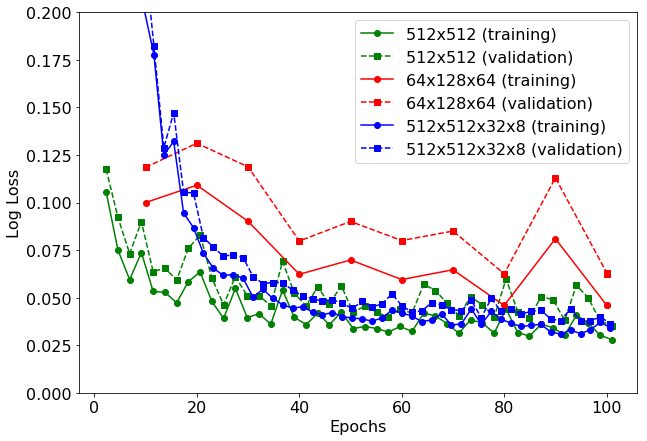

In [104]:
tmp = plt.rc('font', size=16)

plt.figure(figsize=(10,7))
#plt.plot(scores1.epochs,scores1.training_logloss,'-o', color='r')
#plt.plot(scores1.epochs,scores1.validation_logloss,'--s', color='r')

plt.plot(scores2.epochs,scores2.training_logloss,'-o', color='g', label='512x512 (training)')
plt.plot(scores2.epochs,scores2.validation_logloss,'--s', color='g', label='512x512 (validation)')

plt.plot(scores3.epochs,scores3.training_logloss,'-o', color='r', label='64x128x64 (training)')
plt.plot(scores3.epochs,scores3.validation_logloss,'--s', color='r', label='64x128x64 (validation)')

#plt.plot(scores4.epochs,scores4.training_logloss,'-s', color='b')
#plt.plot(scores4.epochs,scores4.validation_logloss,'-s', color='r')

plt.plot(scores6.epochs,scores6.training_logloss,'-o', color='b', label='512x512x32x8 (training)')
plt.plot(scores6.epochs,scores6.validation_logloss,'--s', color='b', label='512x512x32x8 (validation)')

plt.ylim(0,0.2)
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Log Loss')


In [80]:
gbm1 = H2OGradientBoostingEstimator(ntrees=5000, max_depth=5, learn_rate=0.001, sample_rate=0.7, col_sample_rate=0.8,
                                    score_tree_interval=100, stopping_rounds=0)


In [81]:
gbm1.train(x=features, y='pitch_type',training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [82]:
gbm1.confusion_matrix(test)

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



CH,CU,FC,FF,SI,Error,Rate
82.0,0.0,1.0,0.0,0.0,0.0120482,1 / 83
0.0,173.0,0.0,0.0,0.0,0.0,0 / 173
0.0,0.0,112.0,7.0,0.0,0.0588235,7 / 119
0.0,0.0,3.0,353.0,1.0,0.0112045,4 / 357
0.0,0.0,0.0,0.0,113.0,0.0,0 / 113
82.0,173.0,116.0,360.0,114.0,0.0142012,12 / 845


In [78]:
scores1 = gbm1.score_history()


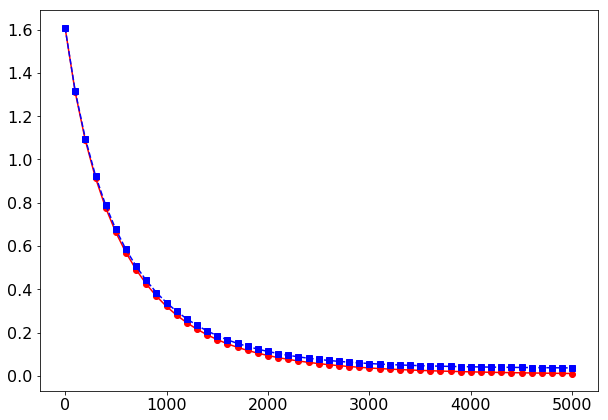

In [90]:
tmp = plt.rc('font', size=16)

plt.figure(figsize=(10,7))
#plt.plot(scores1.epochs,scores1.training_logloss,'--o', color='b')
#plt.plot(scores1.epochs,scores1.validation_logloss,'--o', color='r')

plt.plot(scores1.number_of_trees,scores1.training_logloss,'-o', color='r')
plt.plot(scores1.number_of_trees,scores1.validation_logloss,'--s', color='b')


In [85]:
# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.001, 0.005],
                'max_depth': [3, 5, 9, 15],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0], 
              }

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=features, y='pitch_type',
                training_frame=train,
                validation_frame=valid,
                ntrees=5000,
                score_tree_interval=100, stopping_rounds=0
               )


gbm Grid Build progress: |███████████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_905e82ea42ff0cb458c0f8b6d7eb4581> was cancelled by the user.

In [88]:
grid7 = h2o.get_model('gbm_grid1_model_7')

In [89]:
scores1 = grid7.score_history()


In [98]:
grid7.get_params()['max_depth']

{u'__meta': {u'schema_name': u'ModelParameterSchemaV3',
  u'schema_type': u'Iced',
  u'schema_version': 3},
 u'actual_value': 5,
 u'default_value': 5,
 u'gridable': True,
 u'help': u'Maximum tree depth.',
 u'is_member_of_frames': [],
 u'is_mutually_exclusive_with': [],
 u'label': u'max_depth',
 u'level': u'critical',
 u'name': u'max_depth',
 u'required': False,
 u'type': u'int',
 u'values': []}